Let's load local llm. Using complete method of Ollam class we can complete the given query.

In [1]:
from llama_index.llms.ollama import Ollama
response = Ollama(model="phi3:mini").complete("Nepal is")
print(response)

 Nepal is a landlocked country in South Asia, nestled within the Himalayan range. It shares borders with China to the north and India to the south, east, and west. The capital city of Nepal is Kathmandu, while its largest metropolitan area is the city of Patan (also known as Lalitpur).

Nepal has a rich cultural heritage, famous for its diverse ethnic groups, languages, and traditions. It's also home to Mount Everest, the world's highest peak at 8,849 meters above sea level. The country is divided into three main regions: the mountainous northern region (Terrace Land), central hills, and southern plains (Terai).

Nepal's economy largely depends on agriculture, tourism, and remittances from Nepali citizens working abroad. Despite its natural beauty and cultural richness, it remains one of the least developed countries in terms of GDP per capita. The nation has made significant progress since transitioning to a federal democratic republic system in 2015 after abolishing the monarchy.

To

We should pass the llm model through *Settings* to use that LLM and embedding model as a global llm and global embedding model respectively. Otherwise, the default llm will be used which is OpenAI ChatGPT and might result in error.
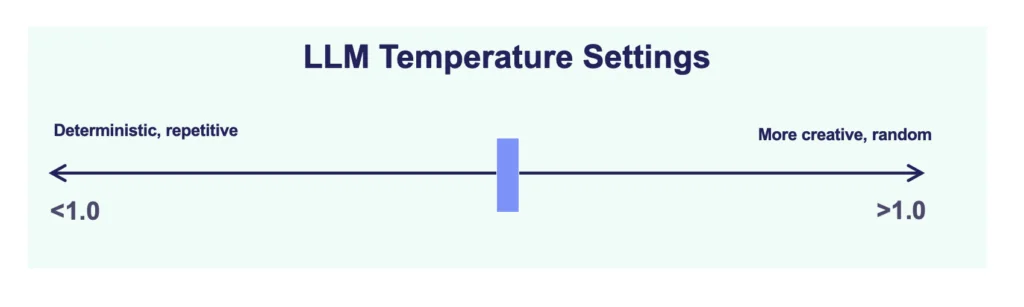

In [2]:
from llama_index.core import Settings
from llama_index.embeddings.ollama import OllamaEmbedding
Settings.llm=Ollama(model="phi3:mini",temperature=0.8,request_timeout=600) #to prevent timeout
Settings.embed_model= OllamaEmbedding(model_name="nomic-embed-text") #this is mentioned to perform better than ChatGPT 3 embedding model
#But should check default phi3:mini embedding as well.


The *SimpleDirectoryReader* is the data connector used in llamaindex that ingest data into documents and nodes. It will itself select the best file reader based on the extension. There are other connector as well in Llamahub which can be used for specific purpose. The *VectorStoreIndex* is a key component of RAG which is used to load a set of documents and build an index from them using *from_documents*. It will correctly parse them and chunk them up. But sometimes we might need more control over them.

This process is called *Transformations* which includes chunking, extracting metadata and embedding each chunk. 

In [16]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
import os
Query2CAD = SimpleDirectoryReader(input_files=["Research_Papers\QUERY2CAD GENERATING CAD MODELS USING NATURAL.pdf"]).load_data()
document_index=VectorStoreIndex.from_documents(Query2CAD) #Splits documents into Node Objects
print(document_index)


Instead of using a loader we can also use a Document directly as well.

In [19]:
from llama_index.core import Document
txt1 = Document(text="text")
print(txt1)

Doc ID: c9f7f0be-0e62-4e4f-9aa9-f0052581e7f7
Text: text


Let's create a customized index with a little bit more control. We can use splitters such as SentenceSplitter, TokenTextSplitter. In general, The SentenceSplitter this tries to keep sentences and paragraphs together. Therefore compared to the original TokenTextSplitter, there are less likely to be hanging sentences or parts of sentences at the end of the node chunk.

In [18]:
from llama_index.core.node_parser import SentenceSplitter

text_splitter = SentenceSplitter(chunk_size=512, chunk_overlap=10)

# global to ensure this textsplitter is used everywhere in the program
Settings.text_splitter = text_splitter 

# per-index
index = VectorStoreIndex.from_documents(
    Query2CAD, transformations=[text_splitter]
)

In [20]:
print(index)

We can also chose to build an index over a list of Node objects. Node are the atomic unit of data in Llamaindex.

In [21]:
nodes = text_splitter.get_nodes_from_documents(Query2CAD)
index=VectorStoreIndex(nodes)

But embedding all your text can be time-consuming and if hosted LLM used costly. So we need to save the embeddings first. This is called persisting to storage. We can use persit() method to do this. To prevent from saving the index again, we can skip the process by seeing if persist directory exists or not and only save if it does not. If it exists then we can use the existing to load index from. In fact we can skip the indexing as well if the persist directory exists and thus can move the splitting document inside if statement as well. We can even skip loading the directory as well.

In [28]:
from llama_index.core import StorageContext, load_index_from_storage
persist_dir = "./jupraglearning"
if not os.path.exists(persist_dir):
    documents=SimpleDirectoryReader("Research_Papers").load_data()
    nodes = text_splitter.get_nodes_from_documents(documents)
    index=VectorStoreIndex(nodes)
    index.storage_context.persist(persist_dir=persist_dir)
else:
    #rebuilding the storage context
    storage_context=StorageContext.from_defaults(persist_dir=persist_dir)
    #loading index
    index=load_index_from_storage(storage_context)

With this the first loading took 54.7s. Then it took 0.2s to load the index.

In [30]:
query_engine = index.as_query_engine()
response=query_engine.query("What is the efficiency of Query2CAD in generating CAD models with LLMs?")
print(response)

 The effectiveness of Query2CAD in producing CAD designs utilizing language models showcases a notable accuracy rate on simpler design questions at an impressive level, demonstrating a success percentage of 95.23% when employing GPT-4 Turbo as the LLM for easy-level queries.


It took 47.2s to answer this query with inbuilt vectorstoreindex of llama-index. The response is quite upto the mark as well.

We can also use Chroma, an open source vector store to store the embeddings from a VectorStoreIndex. If we have already created and stored our embeddings we should load the embeddings directly without loading our document.

In [31]:
%%time
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore

chroma_directory='./chroma_db'
if not os.path.exists(chroma_directory):
# load some documents
    documents = SimpleDirectoryReader("Research_Papers").load_data()
    nodes=text_splitter

# initialize client, setting path to save data
db = chromadb.PersistentClient(path=chroma_directory)

# create collection or get collection
chroma_collection = db.get_or_create_collection("Query2CAD")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# create your index or load your index from stored vectors
index = VectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

# create a query engine and query
query_engine = index.as_query_engine()

CPU times: total: 188 ms
Wall time: 35.4 s


It took 54.2s to create chromadb folder for the first time. We can run the above code again to see how quick it loads after storing the embeddings. The embeddings could be loaded from the chroma in 33.8s after loading the documents which is very high compared to VectorStoreIndex. But splitting the documents might have helped in case of VectorStoreIndex. Need to look into that as well. Now let's try out query engine.

In [32]:
response=query_engine.query("What is the efficiency of Query2CAD in generating CAD models with LLMs?")
print(response)

 The model has shown high effectiveness when handling simple design tasks, with a notable accuracy rate for these types of questions. As complexity increases to medium and hard levels, while maintaining performance above average, it still demonstrates commendable capabilities, albeit with some decrease in precision. This pattern is consistent across various iterations and refinement processes, indicating progressive enhancement over time.


The answer using chromdb has give more clear overview though less specific than VectorStoreIndex here. Need to check with splitting the document with Chroma as well.

We can now look into customizing the stages of querying. We can use different number of top_k which represnets the number of embeddings returned. We can also add post processing with similarity score threshold that gives us lot of data when we have relevant results but no data when we have nothing relevant.

In [37]:
#import required tools
from llama_index.core import get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor

Retrievers define how to efficiently retrieve relevant context from an index when given a query.

In [65]:
# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    #similarity_top_k=3,
)

Response synthesizers generate a response from an LLM using a user query and a given set of retrieved text chunks.

In [66]:
# configure response synthesizer
response_synthesizer = get_response_synthesizer()

Node postprocessors take in sets of retrieved nodes and applies  transformations, filtering or re-ranking logic to them. Here we are applying similarity cutoff to the node_postprocessor. We cab further configure the node processor by using *KeywordNodePostprocessor* which filter nodes by *exclude_keywords* and *required_keywords*. We can configure the response synthesis in query_engine by using from_args method. We can add response_mode parameter with values 'default', 'compact', 'tree_summarize' etc.

In [69]:
# assemble query engine
query_engine = RetrieverQueryEngine.from_args(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    response_mode='compact'
    #node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.2)],
)

Let's query now with these updates.

In [70]:
response=query_engine.query("What is the efficiency of Query2CAD in generating CAD models with LLMs?")
print(response)

 The effectiveness of Query2CAD when utilizing language models (LLMs) to generate Computer-Aided Design (CAD) models exhibits remarkable performance, particularly on simple questions. It achieved a notable accuracy rate of approximately 95.23% for easy-level tasks using GPT-4 Turbo as the LLM. The model also maintained noteworthy efficiency levels for medium and hard challenges with respective accuracies at around 70% and 41%.


We might have to figure out what similarity cut-off to use or use it as default as it gave 'Empty response' in most of the cases. Also it might be better keeping similarty_top_k value low as it increases the retrieval time substantially. For example setting it to 3 will cause the llm to return answer once and refine upon it for the next two times.